#### Validating the Fitbit Against Research Grade Accelerometers in a Free-Living Environment

This code compares physical activity data from research grade accelerometers (called Actigraphs) to the Fitbit, a popular physical activity tracker. Fitbits have been validated in lab environments, but research on how well the Fitbit tracks activity in free-living situations is lacking. Both the Actigraph and the Fitbit track how many steps a user takes on a minute by minute basis, and these step counts will serve as the basis of comparison between the Fitbit and the Actigraph.

A cohort of 20 Fitbit users were recruited to wear both their Fitbit and an Actigraph accelerometer for 7 days. For each study participant, the number of steps recorded from each device are compared graphically and with Pearson's correlation coefficient. From the Actigraph data, minutes of moderate to vigorous physical activity (MVPA) are calculated for each participant, and a scatter plot visualizes the relationship between MVPA and the steps correlation coefficient for each user. The hypothesis is that perhaps the Fitbit matches the Actigraph best when users are more sedentary (i.e., have fewer minutes of MVPA).

In [36]:
import pandas as pd
import numpy as np
import os.path
import glob
import datetime
from scipy.stats import describe
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("ggplot")

Actigraph data are stored in separate .csv files for each participant. The following code loops through each participant file, cleaning the data and appending it to the total DataFrame. 

Date and time variables from the original .csv files are read in as dates (which is why this code takes a particularly long time to run). Date and time are combined into a single variable that is adjusted to the participant's time zone. The data are limited to the dates that the user participated in the study. Minutes of MVPA are defined using Freedson's cutpoint, which classifies MVPA as any movement with an activity count greater than 1951. Minute data is then collapsed into hourly data, summing steps and MVPA. Columns are created to store ID and accelerometer information so that Actigraph data can later be linked to Fitbit data. 

In [85]:
# Creating a list of all Actigraph .csv files
accel_file = glob.glob("/Users/megan/Desktop/MIDS project/Git/Accel CSV data/User*_ActigraphMay.csv")

# Creating a DataFrame that stores user time zone and date range information
dates = pd.read_csv('/Users/megan/Desktop/MIDS project/Git/Dates.csv', index_col=0, parse_dates=['Initial', 'Final'])

# Defining a variable for the MVPA cutpoint
mvpa_cutpoint = 1951

# Creating an empty DataFrame to store individual DataFrames from the following loop
total = pd.DataFrame()

for file in accel_file:
    accel = pd.read_csv(file, skipinitialspace=True, parse_dates=[['Date','Time']]) 
    accel['Date_Time'] = accel['Date_Time'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day, dt.hour, 0))
    
    # Storing the user_id from the filename
    user_id = int(os.path.basename(file).split("_")[0].replace('User',''))
    
    # Adjusting for time zone
    offset = int(dates.loc[user_id].Offset)
    accel['Date_Time'] += datetime.timedelta(hours=offset)
    
    # Limiting dates to the days of the study
    date_range = dates.loc[user_id]
    date_bool1 = np.array(accel.Date_Time > date_range.Initial)
    date_bool2 = np.array(accel.Date_Time < date_range.Final)
    wear_dates = np.logical_and(date_bool1, date_bool2)
    accel = accel[wear_dates]
    
    # Boolean variable classifying each minute as MVPA or not
    accel['MVPA'] = accel['Axis1'] > mvpa_cutpoint
    
    # Grouping by hour and finding out total steps and MVPA per hour
    by_hour = accel.groupby(['Date_Time'])
    hour_totals = by_hour.sum().reset_index()

    # Creating identification columns and appending the user DataFrame to the total DataFrame
    hour_totals['User'] = user_id
    hour_totals['Type'] = 'Actigraph'
    total = total.append(hour_totals, ignore_index=True)

accel_total = total[['User', 'Type', 'Date_Time', 'Steps', 'MVPA']]
accel_total.head()

,User,Type,Date_Time,Steps,MVPA
0,10311,Actigraph,2015-05-16 01:00:00,23,0
1,10311,Actigraph,2015-05-16 02:00:00,5,0
2,10311,Actigraph,2015-05-16 03:00:00,0,0
3,10311,Actigraph,2015-05-16 04:00:00,7,0
4,10311,Actigraph,2015-05-16 05:00:00,27,0


Summary statistics for each participant are calculated and stored in the user_stats DataFrame. The minimum, maximum and average daily steps are stored for each user, as well as total minutes of MVPA over the entire seven day period. 

In [111]:
actigraph = pd.DataFrame()
actigraph = actigraph.append(accel_total)
actigraph['Date_Time'] = actigraph['Date_Time'].apply(lambda dt: datetime.datetime(dt.year, dt.month, dt.day))
daily = actigraph.groupby(['User', 'Date_Time'])['Steps','MVPA'].sum().reset_index()

min_steps = pd.Series()
max_steps = pd.Series()
mean_steps = pd.Series()

for user, user_data in daily.groupby(['User']):  
    data1 = describe(user_data.Steps)
    minimum = data1[1][0]
    maximum = data1[1][1]
    mean = data1[2]

    min_steps = min_steps.append(pd.Series(minimum, index=[user]))
    max_steps = max_steps.append(pd.Series(maximum, index=[user]))
    mean_steps = mean_steps.append(pd.Series(mean, index=[user]))
    
user_stats = pd.DataFrame(min_steps)
user_stats.columns = ['Minimim Steps']
user_stats['Maximum Steps'] = max_steps
user_stats['Average Steps'] = mean_steps

by_user = daily.groupby(['User'])
total_mvpa = by_user.sum()['MVPA']
total_mvpa = pd.DataFrame(total_mvpa)

user_stats['Total MVPA']=total_mvpa.MVPA

user_stats

,Minimim Steps,Maximum Steps,Average Steps,Total MVPA
701,5851,11172,8245.500,421
2130,13,6699,4390.750,208
7373,20,9494,5461.125,209
7685,85,12612,8032.625,439
9412,3231,14734,9393.000,678
10311,771,14688,9871.250,451
10467,4647,19234,9742.125,264
10601,0,12695,6298.625,209
10900,224,8094,4041.500,37
10921,2846,6596,4012.750,42


From the summary statistics stored in the user_stats DataFrame, histograms are created to visualize the distribution of average daily steps and total MVPA for this cohort. 

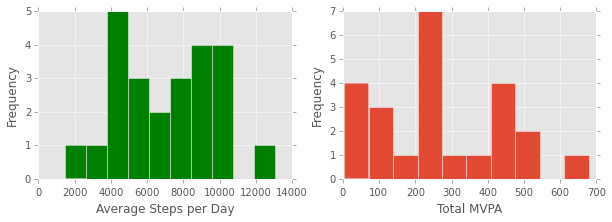

In [110]:
plt.figure(figsize=(10.0, 3.0))

plt.subplot(1, 2, 1)
plt.hist(user_stats['Average Steps'].values, color='g')
plt.xlabel('Average Steps per Day')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
plt.hist(user_stats['Total MVPA'].values)
plt.xlabel('Total MVPA')
plt.ylabel('Frequency')
plt.show()

Fitbit data are stored in a master file that is read into the fitbit DataFrame. The date and minute variables are combined into Date_Time and all other variables are renamed to match the Actigraph data. Data are limited to the dates that the user participated in the study. Data is grouped by hour to match Actigraph data, and columns are created to identify the data by user and type.

In [100]:
# Reading in fitbit data and editing columns to match the Actigraph data
fitbit = pd.read_csv('/Users/megan/Desktop/MIDS project/Git/meas_fitbit_intraday_1wk_4.txt', sep='|', parse_dates=['date'])
fitbit.rename(columns={'user_id':'User', 'date':'Date', 'steps':'Steps'}, inplace=True)
fitbit.sort(['User','Date','minute'], axis=0, inplace=True)
fitbit['Hour'] = (fitbit['minute'] / 60).astype(int) % 24
fitbit.loc[fitbit['minute']==1440, 'Date'] += datetime.timedelta(days=1)
fitbit['Date_Time'] = fitbit[['Date', 'Hour']].apply(lambda row: datetime.datetime(row.Date.year, row.Date.month, row.Date.day, row.Hour, 0), axis=1)

# Dropping dates outside of the date range for each user
fitbit = fitbit.join(dates, on='User')
date_bool1 = np.array(fitbit.Date_Time > fitbit.Initial)
date_bool2 = np.array(fitbit.Date_Time < fitbit.Final)
wear_dates = np.logical_and(date_bool1, date_bool2)
fitbit = fitbit[wear_dates]

# Grouping by hour
by_hour = fitbit.groupby(['User', 'Date_Time'])
hour_totals = by_hour.sum().reset_index()
hour_totals['Type'] = 'Fitbit'
fitbit_total = hour_totals[['User', 'Type', 'Date_Time', 'Steps']]

fitbit_total.head()

,User,Type,Date_Time,Steps
0,701,Fitbit,2015-05-17 01:00:00,0
1,701,Fitbit,2015-05-17 02:00:00,0
2,701,Fitbit,2015-05-17 03:00:00,0
3,701,Fitbit,2015-05-17 04:00:00,0
4,701,Fitbit,2015-05-17 05:00:00,0


A master DataFrame is created combining Actigraph and Fitbit data for all users into one DataFrame. Users who did not provide Fitbit data are dropped from analysis. 

In [41]:
# Concatenating accelerometer and fitbit dataframes into a master dataframe
master = pd.concat([accel_total, fitbit_total])
master.sort(['User','Date_Time','Type'], inplace=True)
master = master[['User', 'Type', 'Date_Time', 'Steps']]

# Dropping users who did not provide Fitbit data
by_user = master.groupby(['User'])
total_minutes = by_user.count()
users_to_drop = total_minutes[total_minutes['Type'] < 200].index
master = master[-master.User.isin(users_to_drop)]

master.head()

,User,Type,Date_Time,Steps
3796,701,Actigraph,2015-05-17 01:00:00,0
0,701,Fitbit,2015-05-17 01:00:00,0
3797,701,Actigraph,2015-05-17 02:00:00,0
1,701,Fitbit,2015-05-17 02:00:00,0
3798,701,Actigraph,2015-05-17 03:00:00,0


A line plot is created for each user, providing a visualization of how well the Actigraph step data and Fitbit step data match up. 

/Users/megan/anaconda/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


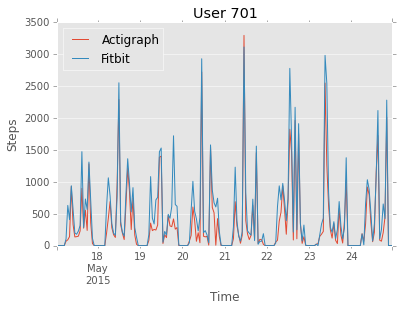

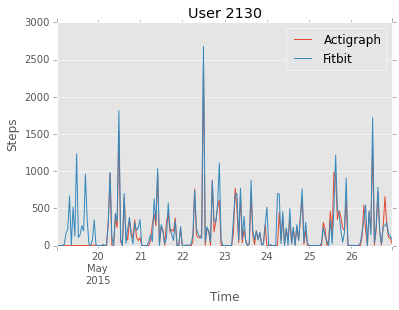

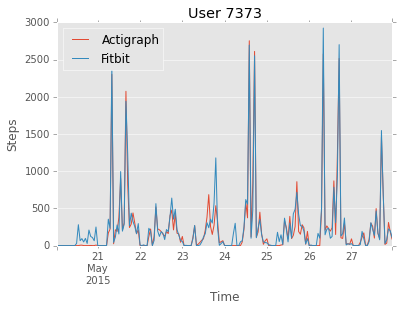

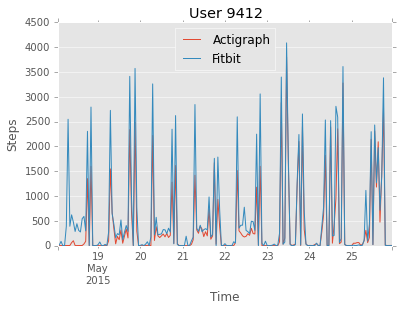

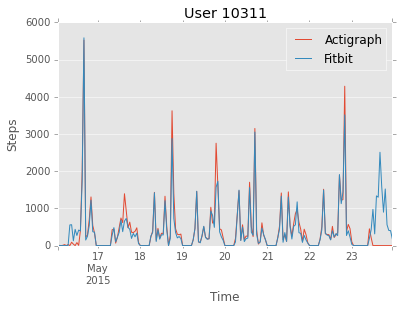

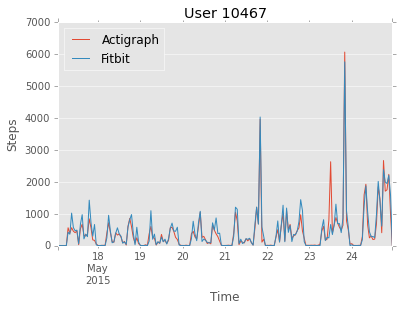

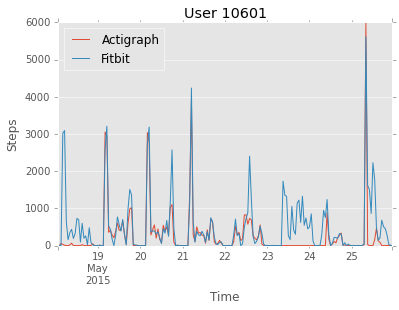

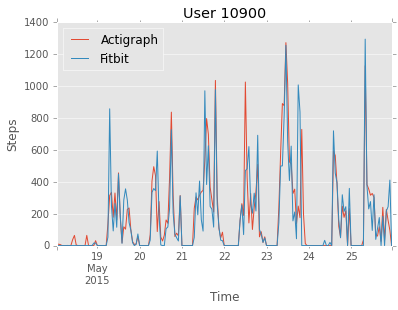

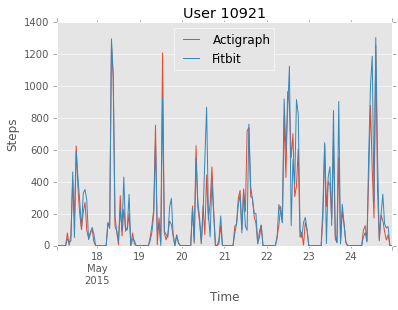

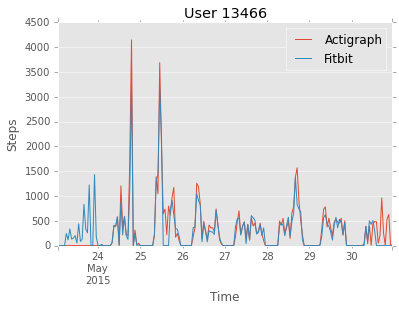

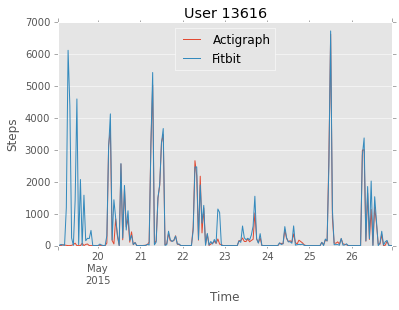

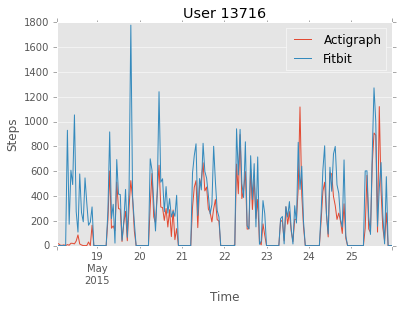

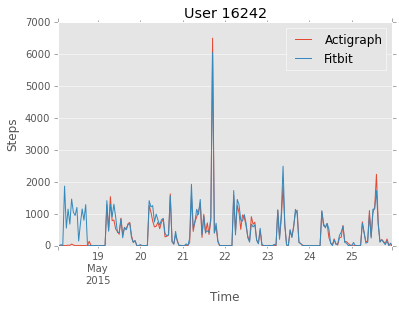

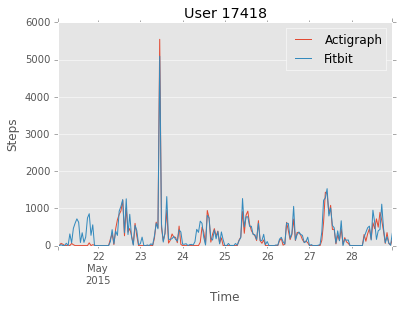

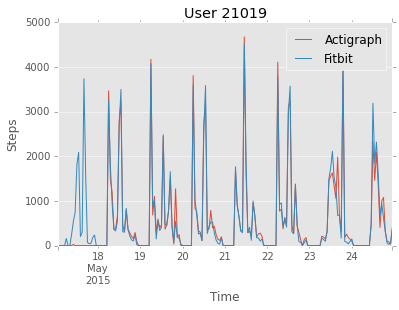

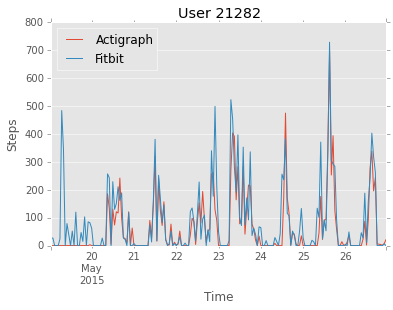

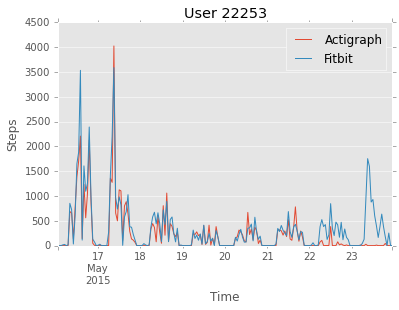

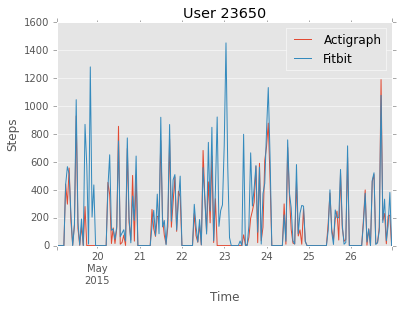

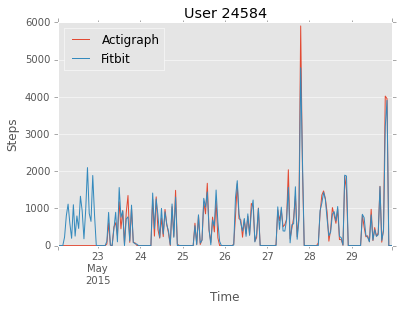

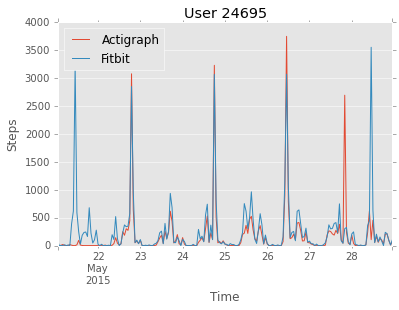

In [42]:
fig = plt.figure()

for user, user_data in master.groupby(['User']):    
    fig, ax = plt.subplots()
    labels = []
    for key, grp in user_data.groupby(['Type']):
        ax = grp.plot(ax=ax, kind='line', x='Date_Time', y='Steps', c=key)
        labels.append(key)
    lines, _ = ax.get_legend_handles_labels()
    ax.legend(lines, labels, loc='best')
    plt.title('User ' + str(user))
    plt.xlabel('Time')
    plt.ylabel('Steps')

  

A Pearson's correlation coefficient is calculated for the Actigraph and Fitbit data provided by each user. These coefficients are stored as a series.

In [43]:
correlation = pd.Series()

for user, user_data in master.groupby(['User']):  
    actigraph = np.array(user_data.Type == 'Actigraph')
    a = user_data[actigraph].Steps
    fitbit = np.array(user_data.Type == 'Fitbit')
    f = user_data[fitbit].Steps
      
    corr = np.corrcoef(a,f)[0,1]
    correlation = correlation.append(pd.Series(corr, index=[user]))

correlation.head()

701      0.948639
2130     0.869982
7373     0.972702
9412     0.938618
10311    0.881483
dtype: float64

A histogram is created to visualize the distribution of correlation coefficients. For the most part, it looks like the step data from the Actigraph and Fibit accelerometers are reasonably well correlated.

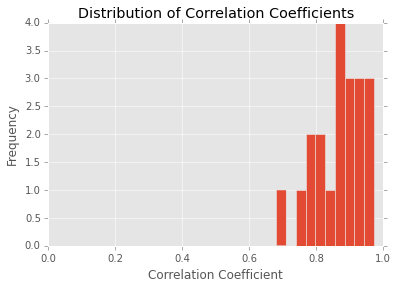

In [47]:
plt.hist(correlation.values)
plt.title('Distribution of Correlation Coefficients')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Frequency')
plt.xlim(0, 1.0)
plt.show()

To dig a little deeper into how well the Fitbit matches the Actigraph, the correlation coefficient for each user is plotted against minutes of MVPA. The hypothesis is that perhaps the Fitbit matches the Actigraph best when users are more sedentary (i.e., have fewer minutes of MVPA). 

From the plot, it appears that the Fitbit may be more accurate when  

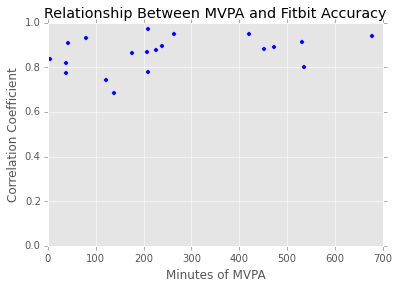

In [49]:
# Creating a dataframe for correlation coefficients and total minutes of MVPA per user
comparison_data = pd.DataFrame(correlation)
comparison_data.columns = ['Coefficient']

by_user = accel_total.groupby(['User'])
total_mvpa = by_user.sum()['MVPA']
total_mvpa = pd.DataFrame(total_mvpa)

comparison_data['MVPA']=total_mvpa.MVPA


# Plotting correlation coefficients against total minutes of MVPA
x = comparison_data.MVPA.values
y = comparison_data.Coefficient.values

plt.scatter(x,y)
plt.title('Relationship Between MVPA and Fitbit Accuracy')
plt.xlabel('Minutes of MVPA')
plt.ylabel('Correlation Coefficient')
plt.xlim(0, 700)
plt.ylim(0, 1.0)
plt.show()